In [91]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from Dilated_Conv_Att import AttDiCEm
from dataset_creation import StockDataset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [124]:
base_path = "price/raw"
df = pd.read_csv(f"{base_path}/AAPL.csv")
print(len(df))

1258


In [125]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000
1,2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800
2,2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100
3,2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600
4,2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500


In [126]:
feature_columns = ['Open','High','Low','Close','Volume']
# feature_columns = ['Close']
filtered_df = df[feature_columns]
seq_len = 10
train_size = int(len(filtered_df) * 0.8)
train_data = filtered_df.iloc[:train_size]
test_data = filtered_df.iloc[train_size:]

In [127]:
train_data.head()

,Open,High,Low,Close,Volume
0,95.108574,96.448570,94.928574,96.424286,91973000
1,96.510002,96.621429,95.657143,95.747147,84093800
2,96.167145,96.898575,95.828575,96.610001,97799100
3,96.864288,97.497147,96.538574,97.205711,82416600
4,97.207146,97.612854,94.585716,94.677139,121999500


In [128]:
scaler = MinMaxScaler()

scaler.fit(train_data.loc[:,['Open','High','Low','Close','Volume']])  # Fit only on train

train_data.loc[:,['Open','High','Low','Close','Volume']] = scaler.transform(train_data[['Open','High','Low','Close','Volume']])
test_data.loc[:,['Open','High','Low','Close','Volume']] = scaler.transform(test_data[['Open','High','Low','Close','Volume']])

/tmp/ipykernel_36276/3959464541.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.22411716 0.20174366 0.24066074 ... 0.03355655 0.0471822  0.03877453]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data.loc[:,['Open','High','Low','Close','Volume']] = scaler.transform(train_data[['Open','High','Low','Close','Volume']])
/tmp/ipykernel_36276/3959464541.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.03906133  0.03928253  0.08325006  0.1134565   0.0951555   0.09156573
  0.13950723  0.27782951  0.21846813  0.1897979   0.09647874  0.06095948
  0.06518731  0.05119053  0.11197765  0.04776999  0.0328282   0.04712172
  0.06485735  0.0662547   0.02457757  0.04739346  0.02387137  0.04467458
  0.03212115  0.06584836  0.14480245  0.06968404  0.06288499  0.06419062
  0.03003833  0.03267515  0.01984

In [129]:
train_data.head()

,Open,High,Low,Close,Volume
0,0.502106,0.508208,0.522536,0.526283,0.224117
1,0.519837,0.510439,0.532074,0.517513,0.201744
2,0.515499,0.514018,0.534318,0.528688,0.240661
3,0.524320,0.521746,0.543613,0.536403,0.196981
4,0.528658,0.523240,0.518048,0.503654,0.309379


In [130]:
try:
    train_dataset = StockDataset(train_data, seq_len, feature_columns)
    test_dataset = StockDataset(test_data, seq_len, feature_columns)
    print("Datasets created successfully!")
except Exception as e:
    print(f"Error creating dataset: {e}")

Datasets created successfully!


In [131]:
train_dataset[0]

(tensor([[0.5021, 0.5082, 0.5225, 0.5263, 0.2241],
         [0.5198, 0.5104, 0.5321, 0.5175, 0.2017],
         [0.5155, 0.5140, 0.5343, 0.5287, 0.2407],
         [0.5243, 0.5217, 0.5436, 0.5364, 0.1970],
         [0.5287, 0.5232, 0.5180, 0.5037, 0.3094],
         [0.5009, 0.4989, 0.5076, 0.4997, 0.3207],
         [0.5041, 0.4985, 0.5066, 0.5167, 0.4686],
         [0.5231, 0.5273, 0.5417, 0.5411, 0.3877],
         [0.5458, 0.5485, 0.5663, 0.5565, 0.3892],
         [0.5628, 0.5537, 0.5788, 0.5722, 0.2455]]),
 tensor(0.5761))

In [132]:
test_dataset[0]

(tensor([[0.6614, 0.6573, 0.6782, 0.6727, 0.0391],
         [0.6639, 0.6612, 0.6872, 0.6723, 0.0393],
         [0.6631, 0.6672, 0.6815, 0.6809, 0.0833],
         [0.6557, 0.6479, 0.6575, 0.6441, 0.1135],
         [0.6227, 0.6279, 0.6299, 0.6131, 0.0952],
         [0.5975, 0.6279, 0.6220, 0.6431, 0.0916],
         [0.6590, 0.6675, 0.6837, 0.6756, 0.1395],
         [0.6745, 0.7223, 0.7015, 0.7250, 0.2778],
         [0.7394, 0.7571, 0.7655, 0.7743, 0.2185],
         [0.7553, 0.7623, 0.7727, 0.7658, 0.1898]]),
 tensor(0.7485))

In [133]:
test_dataset[1]

(tensor([[0.6639, 0.6612, 0.6872, 0.6723, 0.0393],
         [0.6631, 0.6672, 0.6815, 0.6809, 0.0833],
         [0.6557, 0.6479, 0.6575, 0.6441, 0.1135],
         [0.6227, 0.6279, 0.6299, 0.6131, 0.0952],
         [0.5975, 0.6279, 0.6220, 0.6431, 0.0916],
         [0.6590, 0.6675, 0.6837, 0.6756, 0.1395],
         [0.6745, 0.7223, 0.7015, 0.7250, 0.2778],
         [0.7394, 0.7571, 0.7655, 0.7743, 0.2185],
         [0.7553, 0.7623, 0.7727, 0.7658, 0.1898],
         [0.7562, 0.7630, 0.7624, 0.7485, 0.0965]]),
 tensor(0.7483))

In [111]:
from itertools import product
import numpy as np

# Define hyperparameter ranges
param_grid = {
    "hidden_size": [32, 64, 128],
    "kernel_size": [3, 5, 7],
    "dilation_rates": [[1,2,4], [1,2,4,8], [1,2,4,8,16]],
    "num_heads": [2, 4, 8],
    "batch_size": [8, 16, 32],
    "learning_rate": [1e-4, 1e-3, 5e-3],
    "epochs": [20, 50]
}

# Store results
best_loss = float("inf")
best_params = None

# Iterate through all parameter combinations
for params in product(*param_grid.values()):
    # Unpack parameters
    param_dict = dict(zip(param_grid.keys(), params))
    
    print(f"Testing {param_dict}...")

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=param_dict["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=param_dict["batch_size"], shuffle=False)

    # Initialize model
    model = AttDiCEm(
        input_size=len(feature_columns),
        hidden_size=param_dict["hidden_size"],
        kernel_size=param_dict["kernel_size"],
        dilation_rates=param_dict["dilation_rates"],
        num_heads=param_dict["num_heads"]
    )

    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=param_dict["learning_rate"])

    # Training loop
    for epoch in range(param_dict["epochs"]):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()

    # Evaluate model
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            test_loss += criterion(outputs.squeeze(), targets).item()

    avg_test_loss = test_loss / len(test_loader)

    print(f"Test Loss: {avg_test_loss:.4f}")

    # Store best hyperparameters
    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        best_params = param_dict

print("\nBest Hyperparameters:", best_params)

Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 2, 'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 20}...
Test Loss: 0.0018
Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 2, 'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 50}...
Test Loss: 0.0014
Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 2, 'batch_size': 8, 'learning_rate': 0.001, 'epochs': 20}...
Test Loss: 0.0015
Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 2, 'batch_size': 8, 'learning_rate': 0.001, 'epochs': 50}...
Test Loss: 0.0018
Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 2, 'batch_size': 8, 'learning_rate': 0.005, 'epochs': 20}...
Test Loss: 0.0018
Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 2, 'batch_size': 8, 'learning_rate': 0.005, 'epochs': 50}...
Test Loss: 0.0

KeyboardInterrupt: 

Epoch 1/50, Loss: 0.0021111350506544113
Epoch 2/50, Loss: 0.0007503797532990575
Epoch 3/50, Loss: 0.00039850419852882624
Epoch 4/50, Loss: 0.0007621641270816326
Epoch 5/50, Loss: 0.000710794236510992
Epoch 6/50, Loss: 0.0002671628026291728
Epoch 7/50, Loss: 0.001417200779542327
Epoch 8/50, Loss: 0.00023337760649155825
Epoch 9/50, Loss: 0.0010896440362557769
Epoch 10/50, Loss: 0.0009707993594929576
Epoch 11/50, Loss: 0.0005412754835560918
Epoch 12/50, Loss: 0.0003639137139543891
Epoch 13/50, Loss: 0.0013651929330080748
Epoch 14/50, Loss: 0.0008958406979218125
Epoch 15/50, Loss: 0.00021674380695912987
Epoch 16/50, Loss: 0.000676317373290658
Epoch 17/50, Loss: 0.0025556455366313457
Epoch 18/50, Loss: 0.00010056677274405956
Epoch 19/50, Loss: 0.0012911002850160003
Epoch 20/50, Loss: 0.0007355806301347911
Epoch 21/50, Loss: 0.0005980130517855287
Epoch 22/50, Loss: 0.00022951587743591517
Epoch 23/50, Loss: 0.00022218511730898172
Epoch 24/50, Loss: 0.0012019050773233175
Epoch 25/50, Loss: 9.6

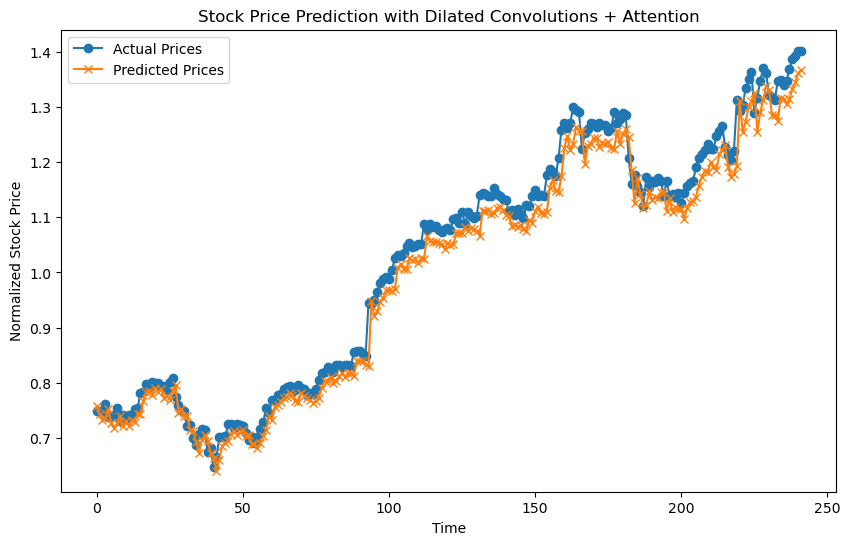

In [134]:
# Define the new model
# Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 8, 'batch_size': 32, 'learning_rate': 0.005, 'epochs': 50}...
# Test Loss: 0.0002
# Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4, 8], 'num_heads': 8, 'batch_size': 8, 'learning_rate': 0.005, 'epochs': 50}...
# Test Loss: 0.0002

# Testing {'hidden_size': 32, 'kernel_size': 3, 'dilation_rates': [1, 2, 4], 'num_heads': 2, 'batch_size': 16, 'learning_rate': 0.001, 'epochs': 50}...
# Test Loss: 0.0005
input_size = len(feature_columns)  # Number of features
hidden_size = 32  # Number of output channels from CNN
kernel_size=3
dilation_rates=[1, 2, 4,8]
num_heads=8
model = AttDiCEm(input_size=input_size, hidden_size=hidden_size, kernel_size=kernel_size, dilation_rates=dilation_rates, num_heads=num_heads)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Test the model
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().numpy())
        actuals.extend(targets.numpy())

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Prices', marker='o')
plt.plot(predictions, label='Predicted Prices', marker='x')
plt.title('Stock Price Prediction with Dilated Convolutions + Attention')
plt.xlabel('Time')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.show()